<a href="https://colab.research.google.com/github/GabrielZenatelli/Aplicando-transfer-learning--CATxDOG/blob/main/TranferLearningCatxDog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento de Redes Neurais com Transfer Learning DIO-UNIMEDBH

In [2]:
#Importando pacotes
%matplotlib inline


#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import os
import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
import tensorflow as tf

In [3]:
# Importando o drive para o colaab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Extraindo imagens do zip e encaminhando para pasta dados
!unzip '/content/drive/MyDrive/Colab Notebooks/kagglecatsanddogs_5340.zip' -d /dados

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /dados/PetImages/Dog/550.jpg  
  inflating: /dados/PetImages/Dog/5500.jpg  
  inflating: /dados/PetImages/Dog/5501.jpg  
  inflating: /dados/PetImages/Dog/5502.jpg  
  inflating: /dados/PetImages/Dog/5503.jpg  
  inflating: /dados/PetImages/Dog/5504.jpg  
  inflating: /dados/PetImages/Dog/5505.jpg  
  inflating: /dados/PetImages/Dog/5506.jpg  
  inflating: /dados/PetImages/Dog/5507.jpg  
  inflating: /dados/PetImages/Dog/5508.jpg  
  inflating: /dados/PetImages/Dog/5509.jpg  
  inflating: /dados/PetImages/Dog/551.jpg  
  inflating: /dados/PetImages/Dog/5510.jpg  
  inflating: /dados/PetImages/Dog/5511.jpg  
  inflating: /dados/PetImages/Dog/5512.jpg  
  inflating: /dados/PetImages/Dog/5513.jpg  
  inflating: /dados/PetImages/Dog/5514.jpg  
  inflating: /dados/PetImages/Dog/5515.jpg  
  inflating: /dados/PetImages/Dog/5516.jpg  
  inflating: /dados/PetImages/Dog/5517.jpg  
  inflating: /dados/PetImages/Dog/5518.jpg 

In [5]:
#Criando o diretório root e determinando as classes e os parâmetros de treino
root = '/dados/PetImages'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]

print(categories)

['/dados/PetImages/Dog', '/dados/PetImages/Cat']


In [6]:
# helper function to load image and return it and input vector
def get_image(path):
    img = tf.keras.utils.load_img(path, target_size=(224, 224))
    x = tf.keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [7]:
#Removendo arquivos Thumbs.db do database
os.remove('/dados/PetImages/Cat/Thumbs.db')
os.remove('/dados/PetImages/Dog/Thumbs.db')

In [8]:
# É necessário uma redução do número de imagens para não ultrapassar o limite de RAM do google collab.
for i in range(200, 12499):
  os.remove(f'/dados/PetImages/Cat/{i}.jpg')
  os.remove(f'/dados/PetImages/Dog/{i}.jpg')

Load all the images from root folder

In [9]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

Randomize the data order.

In [10]:
random.shuffle(data)

create training / validation / test split (70%, 15%, 15%)

In [11]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Separate data for labels.

In [12]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]


Pre-process the data as before by making sure it's float32 and normalized between 0 and 1

In [13]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(61, 2)


In [14]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 402 images from 2 categories
train / validation / test split: 281, 60, 61
training data shape:  (281, 224, 224, 3)
training labels shape:  (281, 2)


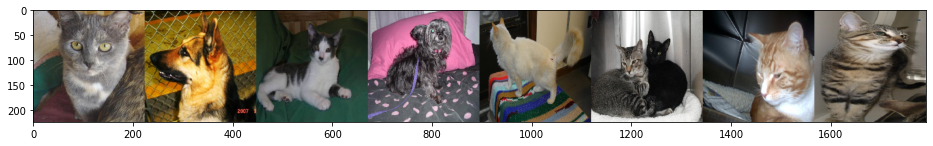

In [15]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [tf.keras.utils.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

In [16]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 [==============================] - 25s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [17]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

In [18]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
history = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))

Epoch 1/10
3/3 [==============================] - 189s 58s/step - loss: 1.0659 - accuracy: 0.5374 - val_loss: 0.6950 - val_accuracy: 0.5667
Epoch 2/10
3/3 [==============================] - 181s 57s/step - loss: 0.7055 - accuracy: 0.5658 - val_loss: 0.9717 - val_accuracy: 0.4333
Epoch 3/10
3/3 [==============================] - 186s 57s/step - loss: 0.7624 - accuracy: 0.5053 - val_loss: 0.5671 - val_accuracy: 0.6500
Epoch 4/10
3/3 [==============================] - 184s 57s/step - loss: 0.6115 - accuracy: 0.6050 - val_loss: 0.5347 - val_accuracy: 0.8000
Epoch 5/10
3/3 [==============================] - 186s 59s/step - loss: 0.5147 - accuracy: 0.8221 - val_loss: 0.4727 - val_accuracy: 0.8333
Epoch 6/10
3/3 [==============================] - 185s 59s/step - loss: 0.4769 - accuracy: 0.8505 - val_loss: 0.4435 - val_accuracy: 0.8500
Epoch 7/10
3/3 [==============================] - 180s 56s/step - loss: 0.4407 - accuracy: 0.8648 - val_loss: 0.4570 - val_accuracy: 0.8500
Epoch 8/10
3/3 [====

A precisão da validação chegou próximo 87%, mesmo com a baixa quantidade de imagens que foram utilizadas mostrando um dos beneficios de utilizar técnica transfer learning em modelos já pré treinados como o VGG.

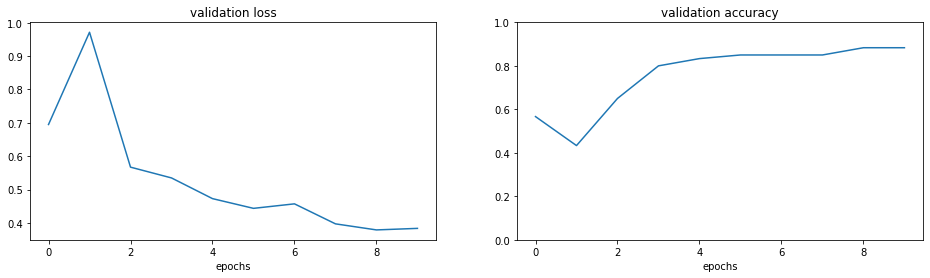

In [22]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Aqui temos os gráficos de validação do modelo para vizualizar o ganho de accuracy com o andar das epochs.

In [24]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.46078240871429443
Test accuracy: 0.8032786846160889
